In [1]:
import numpy as np
from koopman.simulation.simulator import rk4_step, simulate
from koopman.simulation.systems import Pendulum
import matplotlib.pyplot as plt
from scipy.linalg import expm
from spatialmath.base import *

import jax
import jax.numpy as jnp

pendulum = Pendulum(Pendulum.Params())

In [2]:
def pendulum_dynamics(x, u):
    theta, omega = x
    theta_dot = jnp.array([omega])
    omega_dot = -pendulum.params.g / pendulum.params.l * jnp.sin(theta) - pendulum.params.b * omega + u
    
    return jnp.array([theta_dot, omega_dot]).squeeze()

Jx = jax.jacfwd(pendulum_dynamics, argnums=0)
Ju = jax.jacfwd(pendulum_dynamics, argnums=1)

In [3]:
u = np.zeros(1)
theta0 = np.pi/2 - 0.1
omega0 = 0.0

x0 = jnp.array([theta0, omega0])
u0 = jnp.array([0.0])              # no torque

f0 = pendulum_dynamics(x0, u0)
A = Jx(x0, u0)  # Jacobian w.r.t. x
B = Ju(x0, u0)  # Jacobian w.r.t. u

linear_dynamics = lambda x, u : f0 + A @ (x - x0) + B @ (u - u0)

H = 50
dt = 0.02
t = np.arange(0, (H+1)*dt, dt)

xhist = np.zeros((H + 1, 2))
xhist[0] = [theta0, omega0]

xhist_linear = np.zeros((H + 1, 2))
xhist_linear[0] = [theta0, omega0]

for i in range(0, H):
    xcurr = xhist[i]    
    xhist[i+1] = rk4_step(pendulum.dynamics, xcurr, u, dt)

    # Compute the next state using RK4
    xcurr = xhist_linear[i]    
    xhist_linear[i+1] = rk4_step(linear_dynamics, xcurr, u, dt)

Text(0, 0.5, 'Angle (rad)')

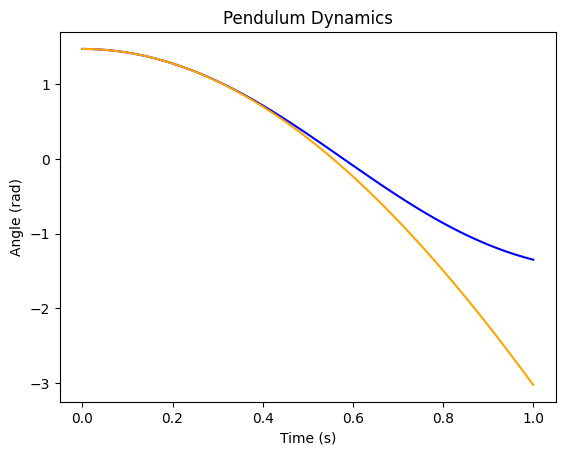

In [4]:
fig, ax = plt.subplots()

ax.plot(t, xhist[:, 0], label='Pendulum', color='blue')
ax.plot(t, xhist_linear[:, 0], label='Linearized', color='orange')


ax.set_title('Pendulum Dynamics')
ax.set_xlabel('Time (s)')
ax.set_ylabel('Angle (rad)')

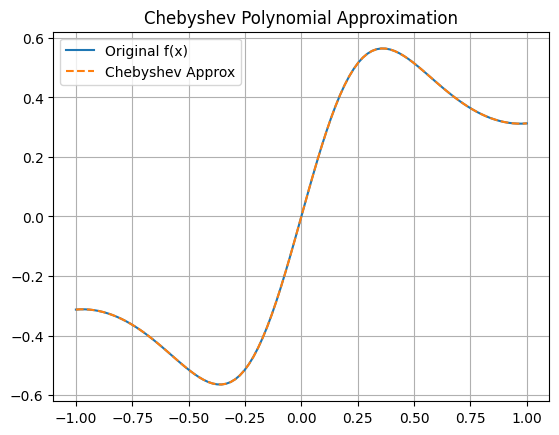

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from numpy.polynomial.chebyshev import chebfit, chebval
from numpy.polynomial.chebyshev import Chebyshev

# Function to approximate
f = lambda x: np.sin(x) * np.exp(np.cos(3*x))

# Approximate on [-1, 1]
x = np.linspace(-1, 1, 100)
y = f(x)

# Fit Chebyshev polynomial of degree N
N = 20
coeffs = chebfit(x, y, deg=N)
T = Chebyshev(coeffs)

# Evaluate approximation
y_approx = chebval(x, coeffs)

# Plot
plt.plot(x, y, label="Original f(x)")
plt.plot(x, y_approx, "--", label="Chebyshev Approx")
plt.legend()
plt.title("Chebyshev Polynomial Approximation")
plt.grid(True)
plt.show()

In [6]:
from jax import jacfwd, vmap

def chebyshev_series(x, order):
    """
    Compute Chebyshev series expansion of x up to given order.
    """
    # Chebyshev polynomials
    Ts = [1, x]
    for _ in range(2, order + 1):
        Ts.append(2 * x * Ts[-1] - Ts[-2])
    
    return jnp.array(Ts)[:, None] # shape (order + 1, x.shape[0])

def build_liftings(order, xmin, xmax):
    S = jnp.diag(2.0 / (xmax - xmin))
    S_inv = jnp.linalg.inv(S)
    
    b = -(xmax + xmin) / (xmax - xmin)
    
    def scale_x(x):
        return S @ x + b
    
    def phi(x):
        nx = x.shape[0]
        x = scale_x(x)
        
        Ts_by_xi = {
            i : chebyshev_series(x[i], order) for i in range(nx)
        }

        return jnp.concatenate([
            *(Ts_by_xi[0][1:])
        ])
    
    phi_jac = jacfwd(phi)
    
    def phi_dot(x, xdot):        
        J = phi_jac(x)         # shape (nz, nx)
        return J @ xdot        # shape (nz,)

    batch_phi = vmap(phi)
    batch_phi_dot = vmap(phi_dot)
    
    return batch_phi, batch_phi_dot, S, S_inv, b

In [7]:
# %%timeit

# x = 0.32 * jnp.ones((1000, 1))
# xdot = 0.77 * jnp.ones((1000, 1))

# px = phi(x)
# px_dot = phi_dot(x, xdot)

In [8]:
l, h = -3.0, 3.0
w = 2.0

phi, phi_dot, S, S_inv, b = build_liftings(order=10, xmin=jnp.array([l]), xmax=jnp.array([h]))

xs = np.random.uniform(l, h, (1000, 1))
xs_dot = np.sin(w * xs)

phi_xs = phi(xs).T
phi_xs_dot = phi_dot(xs, xs_dot).T

In [9]:
A = phi_xs_dot @ jnp.linalg.pinv(phi_xs)

print(f"{phi_xs.shape=}")
print(f"{phi_xs_dot.shape=}")
print(f"A shape: {A.shape}")

phi_xs.shape=(10, 1000)
phi_xs_dot.shape=(10, 1000)
A shape: (10, 10)


In [10]:
eval_xs = np.random.uniform(l, h, (200, 1))
eval_xs_dot = np.sin(w * eval_xs)

eval_phis = phi(eval_xs)
eval_phis_dot = eval_phis @ A.T
eval_scaled_xs_dot_approx = eval_phis_dot[:, :1]

eval_xs_dot_approx = eval_scaled_xs_dot_approx @ S_inv.T

print((eval_xs_dot_approx - eval_xs_dot).mean())

0.0002048309


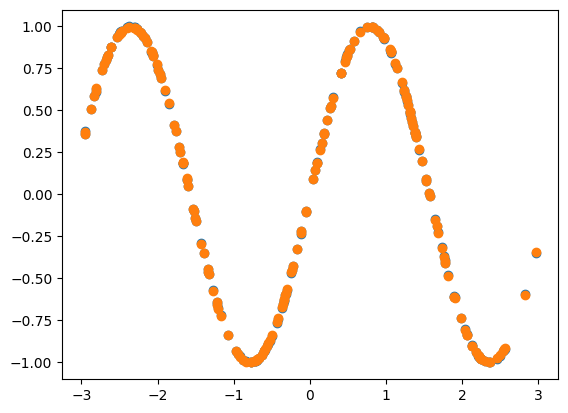

In [11]:
plt.scatter(eval_xs, eval_xs_dot, label="Original Dynamics")
plt.scatter(eval_xs, eval_xs_dot_approx, label="Approx Dynamics")

plt.show()

In [234]:
def build_liftings(order, xmin, xmax):
    S = jnp.diag(2.0 / (xmax - xmin))
    
    S_inv = jnp.linalg.inv(S)
    
    b = -(xmax + xmin) / (xmax - xmin)
    
    def scale_x(x):
        return S @ x + b

    def phi(x):
        nx = x.shape[0]
        # x = scale_x(x)
        K = order
        
        θ, ω = x
        obs = [θ, ω]

        # 2) Fourier in θ
        for k in range(1, K+1):
            obs += [jnp.sin(k*θ), jnp.cos(k*θ)]

        # 3) cross‐terms ω·sin/cos
        for k in range(1, K+1):
            obs += [ω*jnp.sin(k*θ), ω*jnp.cos(k*θ)]
        
        for k in range(1, K+1):
            obs += [ω**2 * jnp.sin(k*θ), ω**2 * jnp.cos(k*θ)]
        
        # 4) energy invariant
        H = 1/2 * ω**2 + pendulum.params.g * (1 - jnp.cos(θ))
        obs.append(H)

        return jnp.stack(obs)
        
    phi_jac = jacfwd(phi)
    
    def phi_dot(x, xdot):        
        J = phi_jac(x)         # shape (nz, nx)
        return J @ xdot        # shape (nz,)

    batch_phi = vmap(phi)
    batch_phi_dot = vmap(phi_dot)
    
    return batch_phi, batch_phi_dot, S, S_inv, b

In [235]:
low = jnp.array([-np.pi, -3.0])
high = jnp.array([np.pi, 3.0])

N = 10_000

thetas = np.random.uniform(low[0], high[0], N)
omegas = np.random.uniform(low[1], high[1], N)

us = np.zeros((N, pendulum.nu))
xs = np.column_stack((thetas, omegas))
xs_dot = pendulum.dynamics(xs, us)

In [236]:
phi, phi_dot, S, S_inv, b = build_liftings(order=6, xmin=low, xmax=high)

phi_xs = phi(xs).T
phi_xs_dot = phi_dot(xs, xs_dot).T

nz = phi_xs.shape[0]

assert np.allclose(xs.T, phi_xs[:pendulum.nx, :])
assert np.allclose(xs_dot.T, phi_xs_dot[:pendulum.nx, :])

print(f"{phi_xs.shape=}")
print(f"{phi_xs_dot.shape=}")
print(phi_xs_dot[-1, :])

phi_xs.shape=(39, 10000)
phi_xs_dot.shape=(39, 10000)
[ 1.9081390e-06 -4.5818842e-07 -1.0132510e-08 ...  9.7943121e-07
  1.8137707e-06 -8.9474997e-07]


In [237]:
A = phi_xs_dot @ jnp.linalg.pinv(phi_xs)
print(f"A shape: {A.shape}")

A shape: (39, 39)


In [238]:
# Grid bounds
theta_lo, omega_lo = -4*np.pi, -4
theta_hi, omega_hi = 4*np.pi, 4

# Grid resolution
num_points = 20

# Create grid of (theta, omega)
theta_vals = np.linspace(theta_lo, theta_hi, num_points)
omega_vals = np.linspace(omega_lo, omega_hi, num_points)
Theta, Omega = np.meshgrid(theta_vals, omega_vals)  # shape (num_points, num_points)

# Flatten grid for vectorized computation
grid_points = np.stack([Theta.ravel(), Omega.ravel()], axis=-1)  # shape (N², 2)

In [239]:
grid_points_dot = pendulum.dynamics(grid_points, np.zeros((grid_points.shape[0], pendulum.nu)))

phi_grid_points = phi(grid_points)
phi_grid_points_dot = phi_grid_points @ A.T

grid_points_dot_est = phi_grid_points_dot[:, :pendulum.nx]

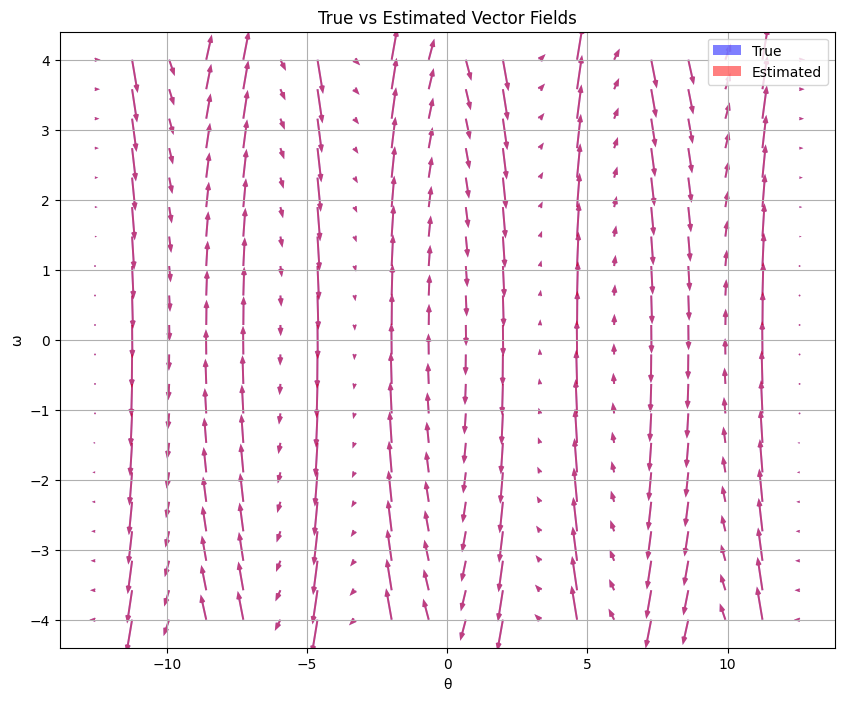

In [240]:
# Plot
plt.figure(figsize=(10, 8))
plt.quiver(grid_points[:, 0], grid_points[:, 1],
           grid_points_dot[:, 0], grid_points_dot[:, 1],
           color='blue', alpha=0.5, label='True',
           angles='xy', scale_units='xy', scale=20,
           width=0.0025, headwidth=3, headlength=4)

plt.quiver(grid_points[:, 0], grid_points[:, 1],
           grid_points_dot_est[:, 0], grid_points_dot_est[:, 1],
           color='red', alpha=0.5, label='Estimated',
           angles='xy', scale_units='xy', scale=20,
           width=0.0025, headwidth=3, headlength=4)

plt.xlabel("θ")
plt.ylabel("ω")
plt.title("True vs Estimated Vector Fields")
plt.legend()
plt.grid(True)
plt.show()

In [249]:
u = np.zeros(1)
theta0 = 1.0
omega0 = 0.0

x0 = np.array([theta0, omega0])
u0 = np.array([0.0])              # no torque

H = 100
dt = 0.02
t = dt * np.arange(0, H+1, 1)

f0 = pendulum_dynamics(x0, u0)
A_linear = Jx(x0, u0)  # Jacobian w.r.t. x
B_linear = Ju(x0, u0)  # Jacobian w.r.t. u

linear_dynamics = lambda x, u : f0 + A_linear @ (x - x0) + B_linear @ (u - u0)

xhist = np.zeros((H + 1, 2))
xhist[0] = x0

zhist_koop = np.zeros((H + 1, nz))
zhist_koop[0] = phi(x0[None, :])

xhist_linear = np.zeros((H + 1, 2))
xhist_linear[0] = x0

A_koop_discrete = expm(A * dt)

def wrap_to_interval(x):
    return ((x + 1) % 2) - 1

for i in range(0, H):
    xcurr = xhist[i]
    xhist[i+1] = rk4_step(pendulum.dynamics, xcurr, u, dt)

    # Compute the next state using RK4
    zcurr = zhist_koop[i]
    zhist_koop[i+1] = A_koop_discrete @ zcurr
    # zhist_koop[i+1][0] = wrap_to_interval(zhist_koop[i+1][0])
    
    xcurr_linear = xhist_linear[i]
    xhist_linear[i+1] = rk4_step(linear_dynamics, xcurr_linear, u, dt)

xhist_pred = zhist_koop[:, :pendulum.nx]
# xhist_pred = np.array((zhist_koop[:, :pendulum.nx] - b[None, :]) @ S_inv.T)

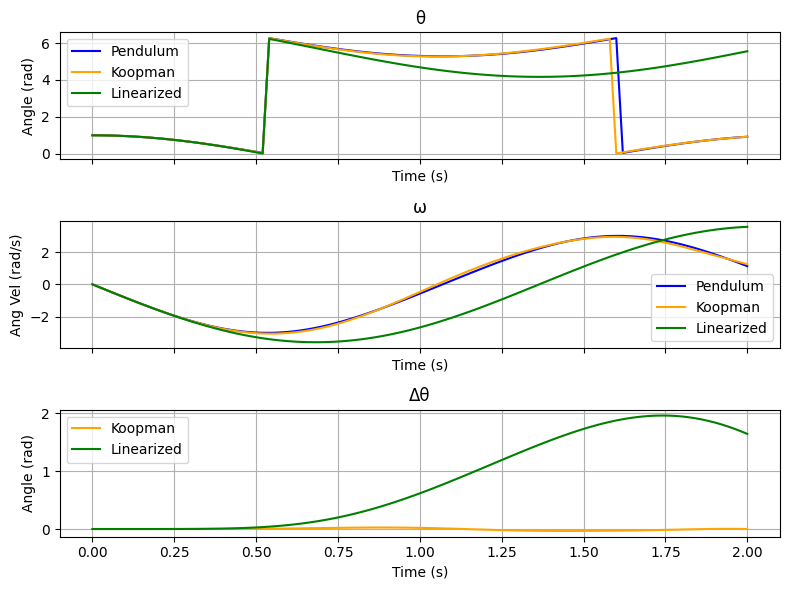

In [250]:
fig, ax = plt.subplots(3, 1, figsize=(8, 6), sharex=True)

ax[0].plot(t, wrap_0_2pi(xhist[:, 0]), label='Pendulum', color='blue')
ax[0].plot(t, wrap_0_2pi(xhist_pred[:, 0]), label='Koopman', color='orange')
ax[0].plot(t, wrap_0_2pi(xhist_linear[:, 0]), label='Linearized', color='green')

ax[0].set_title('θ')
ax[0].set_xlabel('Time (s)')
ax[0].set_ylabel('Angle (rad)')
ax[0].grid()
ax[0].legend()

ax[1].plot(t, xhist[:, 1], label='Pendulum', color='blue')
ax[1].plot(t, xhist_pred[:, 1], label='Koopman', color='orange')
ax[1].plot(t, xhist_linear[:, 1], label='Linearized', color='green')

ax[1].set_title('ω')
ax[1].set_xlabel('Time (s)')
ax[1].set_ylabel('Ang Vel (rad/s)')
ax[1].grid()
ax[1].legend()

koopman_angular_error = angdiff(xhist[:, 0], xhist_pred[:, 0])
linearization_angular_error = angdiff(xhist[:, 0], xhist_linear[:, 0])

ax[2].plot(t, koopman_angular_error, label='Koopman', color='orange')
ax[2].plot(t, linearization_angular_error, label='Linearized', color='green')
ax[2].set_title('Δθ')
ax[2].set_xlabel('Time (s)')
ax[2].set_ylabel('Angle (rad)')
ax[2].legend()
ax[2].grid()

plt.tight_layout()
plt.show()